In [111]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn 
import matplotlib.pyplot as plt

## Supress scientific notation
pd.options.display.float_format = '{:.4f}'.format

In [112]:
## read data from csv
dfRaw = pd.read_csv("dataset.csv",index_col='DriverId')
dfRaw['ts']= pd.to_datetime(dfRaw.ts)
dfRaw

,EventName,Latitude,Longitude,Speed km/h,ts
DriverId,,,,,
0,Timed Event,34.1866,-118.0881,64.0000,2017-11-01 00:00:02.430
0,Distance Event,34.1861,-118.0892,53.0000,2017-11-01 00:00:05.600
0,Distance Event,34.1864,-118.0896,34.0000,2017-11-01 00:00:13.640
0,Distance Event,34.1875,-118.0889,33.0000,2017-11-01 00:00:26.070
0,Distance Event,34.1887,-118.0865,32.0000,2017-11-01 00:00:35.090
...,...,...,...,...,...
88,Timed Event,34.8839,-117.8878,8.0000,2017-11-16 21:27:35.010
88,Engine turned off,34.8830,-117.8878,0.0000,2017-11-16 21:28:05.280
88,Engine started,34.8867,-117.8866,0.0000,2017-11-16 22:08:57.880


Number of drivers: 89
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
          NumEvents
DriverId           
0             17345
1             20694
2             11945
3               819
4              6811
5             24152
6              5700
7             12693
8             19606
9              3928


Text(0, 0.5, 'Number of drivers')

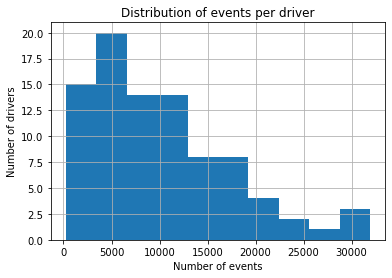

In [113]:
Driver_Index=np.unique(dfRaw.index.to_numpy())
print("Number of drivers: {}".format(len(Driver_Index)))
print(Driver_Index.view())
dfEventPerDriver=pd.DataFrame(dfRaw.groupby("DriverId").size(),columns=['NumEvents'])
print(dfEventPerDriver.head(10))
#Distribution of events per driver 
dfEventPerDriver.sort_values(by='NumEvents',ascending = False,inplace = True)
eventsHist = dfEventPerDriver['NumEvents'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

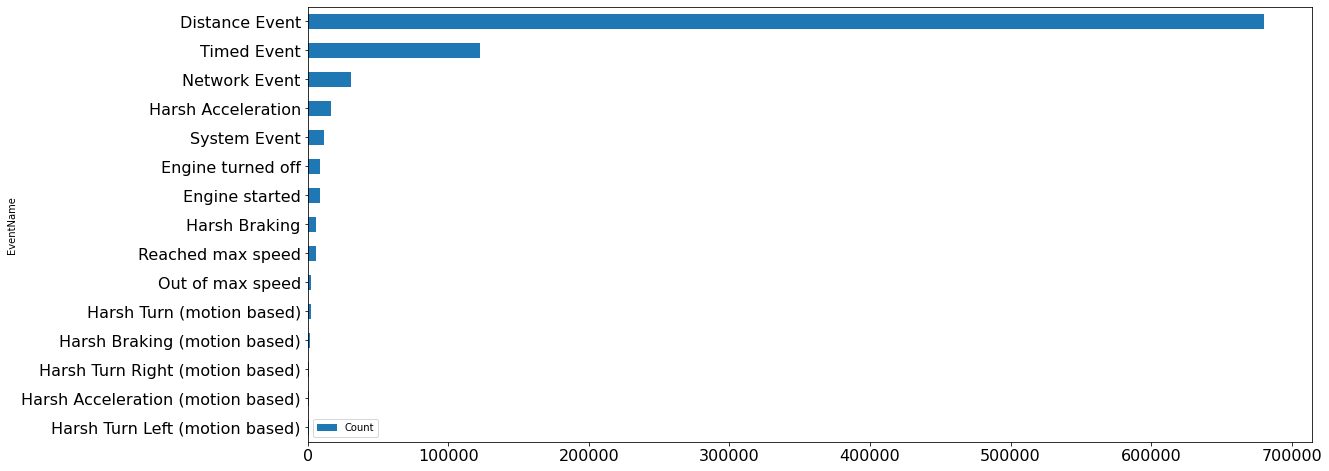

In [114]:
Event_Hist=pd.DataFrame(dfRaw.groupby(['EventName']).size(),columns=["Count"]).sort_values(by='Count', ascending=True)

Event_Hist.plot.barh(figsize=(18,8),fontsize = 16)

In [115]:
RELEVANT_EVENTS = ['Harsh Acceleration' , 'Harsh Braking' ,
        'Harsh Turn (motion based)'     ,'Harsh Braking (motion based)'  , 'Harsh Acceleration (motion based)',
        'Harsh Turn Left (motion based)','Harsh Turn Right (motion based)']


def prepData(dfRaw, minRecordsPerSubscriber = 50):
    dfRaw.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfRaw),"***")
    
    #Remove NAs
    dfRaw = dfRaw.dropna()
    print("Removed NAs. Length:",len(dfRaw))

    ## Filter out unwanted events
    df = dfRaw[dfRaw.EventName.isin(RELEVANT_EVENTS)]
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    
    ## Filter out users with too few samples
    eventCountPerDriver = df.groupby('DriverId')['DriverId'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.DriverId.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))

    return(df)

df = prepData(dfRaw)


*** Starting data prep. Length: 899611 ***
Removed NAs. Length: 899611
Keeping only events that are relevant for modeling. Length: 28403
Filtering users with too few samples. Length: 28152


Text(0, 0.5, 'Number of drivers')

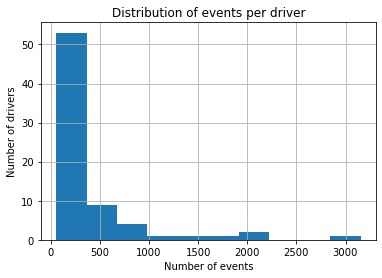

In [116]:
relevantEventsPerSubscriber = df.groupby('DriverId').agg({"EventName":"count"}).sort_values(by='EventName',ascending = False)

eventsHist = relevantEventsPerSubscriber['EventName'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

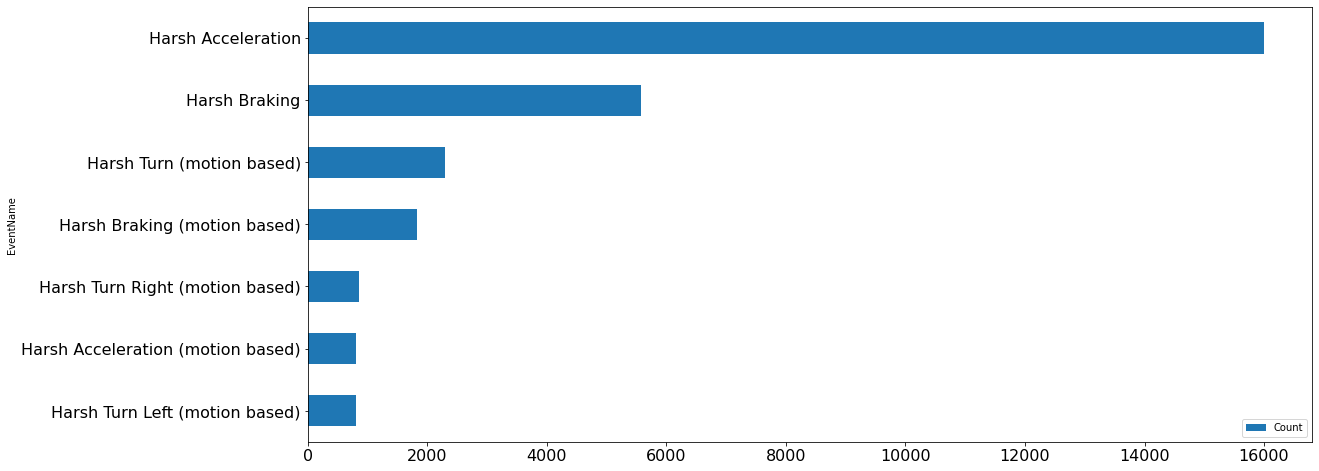

In [117]:
Event_Hist=pd.DataFrame(df.groupby(['EventName']).size(),columns=["Count"]).sort_values(by='Count', ascending=True)

Event_Hist.plot.barh(figsize=(18,8),fontsize = 16)

In [118]:
def total_time(oneDriver):
    return (oneDriver["ts"].values[-1]-oneDriver["ts"].values[0])/np.timedelta64(1, 'm')

## Calculate the overall distance made by each driver
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_time).reset_index(name='time')    
    return dfDistancePerDriver

distancePerDriver = calculate_overall_distance_travelled(dfRaw)
distancePerDriver

,DriverId,time
0,0,25399.7132
1,1,25365.0170
2,2,25376.5918
3,3,25398.3647
4,4,25349.6737
...,...,...
84,84,25346.5500
85,85,25352.8150
86,86,25307.7133
87,87,25326.6463


## Feature engineering
We define a feature set as the normalized number of events per type. For each behavioral event, we count the number of events and divide by total driving time.

In [128]:
## Transform the events data frame to a features data frame (column for each type of relevant event)
def create_feature_set(df, distancePerDriver):
    dfEventAggByDriver = df.groupby(['DriverId','EventName']).size().to_frame().rename(columns={0:"count"}).reset_index()

    ## Pivot events into columns
    dfEventMatrix = dfEventAggByDriver.pivot(index='DriverId',columns='EventName', values='count').add_prefix('F_').fillna(0).reset_index()
    dfEventMatrix = dfEventMatrix.merge(distancePerDriver, how = 'inner',on='DriverId')
    dfEventMatrix.set_index('DriverId', inplace=True)
    
    featureCols = [col for col in dfEventMatrix if col.startswith('F_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['time'], axis=0)

    dfFeatureSet = dfEventMatrix[featureCols]
    
    return dfFeatureSet

features = create_feature_set(df,distancePerDriver)
features

,F_Harsh Acceleration,F_Harsh Acceleration (motion based),F_Harsh Braking,F_Harsh Braking (motion based),F_Harsh Turn (motion based),F_Harsh Turn Left (motion based),F_Harsh Turn Right (motion based)
DriverId,,,,,,,
0,0.0111,0.0000,0.0034,0.0018,0.0010,0.0010,0.0006
1,0.0041,0.0000,0.0017,0.0004,0.0000,0.0004,0.0003
2,0.0076,0.0004,0.0027,0.0012,0.0005,0.0001,0.0000
4,0.0026,0.0000,0.0033,0.0011,0.0021,0.0015,0.0004
5,0.0126,0.0002,0.0030,0.0010,0.0035,0.0007,0.0019
...,...,...,...,...,...,...,...
84,0.0065,0.0000,0.0021,0.0072,0.0000,0.0001,0.0000
85,0.0035,0.0000,0.0025,0.0000,0.0000,0.0000,0.0000
86,0.0012,0.0000,0.0014,0.0006,0.0002,0.0000,0.0000


Since there are two types of systems (motion based and not), we will look at one at a time and not join the two as the values and their proportions might be incomparable. In addition, we'll ignore the inaccurate over speeding event, as noted earlier. 

In [131]:
features = features.rename(columns={'F_Harsh Acceleration (motion based)': "Harsh Acceleration",
                                    'F_Harsh Braking (motion based)': "Harsh Braking",
                                   'F_Harsh Turn (motion based)':"Harsh Turning"},copy =False)

# select only motion based
features = features[['Harsh Acceleration','Harsh Braking','Harsh Turning']]

features

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0000,0.0018,0.0010
1,0.0000,0.0004,0.0000
2,0.0004,0.0012,0.0005
4,0.0000,0.0011,0.0021
5,0.0002,0.0010,0.0035
...,...,...,...
84,0.0000,0.0072,0.0000
85,0.0000,0.0000,0.0000
86,0.0000,0.0006,0.0002


### Scatterplot matrix of features

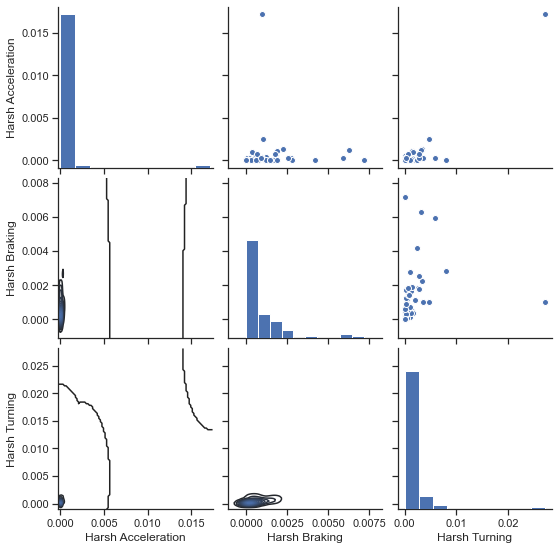

In [132]:
import seaborn as sns
sns.set(style="ticks",font_scale=1.00)
g = sns.PairGrid(features)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot,n_levels=15)

All features are skewed to the right with a long tail. On the diagnoal, we see a histogram of all features. On the upper triangle we see a scatterplot of each pair of features, and on the bottom triangle we see a KDE (Kernel Density Estimation) of each pair of features

### Outliers handling
We wish to remove/adjust outliers as they affect many statistical approaches. In order to remove these, we'll transform the features to normal (using a box-cox transformation) and remove based on *mean + k*std's* rule. A second approach could be to truncate the tail using some constant, but it will be more difficult to find this threshold than the standard deviation rule. A third option is to remove outliers on all three dimensions (using a multivariate normal distribution, for example).

This code performs the first option, box-cox transformation:

x[ 1.1 12.   2.   3.   4.   5.  67.   8.   9.   9.   9.  90.1  1.   2.9]
y[ 1.1 12.   2.   3.   4.   5.  67.   8.   9.   9.   9.   1.   1.   2.9]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


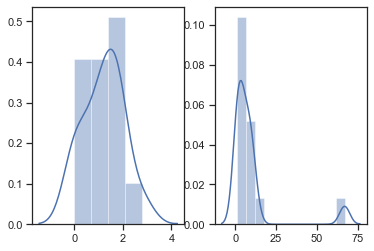

In [133]:
#Box-cox transformation
from scipy.stats import boxcox
from scipy.special import inv_boxcox
x= np.array([1.1,12,2,3,4,5,67,8,9,9,9,90.1,1,2.9])
X,alpha=boxcox(x)
X[11]=0
y=inv_boxcox(X,alpha)
print("x{}\ny{}".format(x,y))

fig, ax =plt.subplots(1,2)
sns.distplot(X, ax=ax[0])
sns.distplot(y, ax=ax[1])
fig.show()

In [134]:
import scipy.stats as st

def transform_to_normal(x,min_max_transform = False):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    if min_max_transform:
        xt = (xt - np.min(xt)) / (np.max(xt)-np.min(xt))
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal(x,min_max_transform =True)))
transFeatures.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0358,0.7057,0.3614
1,0.0358,0.2119,0.0000
2,0.3305,0.5488,0.2011
4,0.0000,0.5369,0.5927
5,0.1966,0.4845,0.7881


### Scatter plot matrix of transformed features

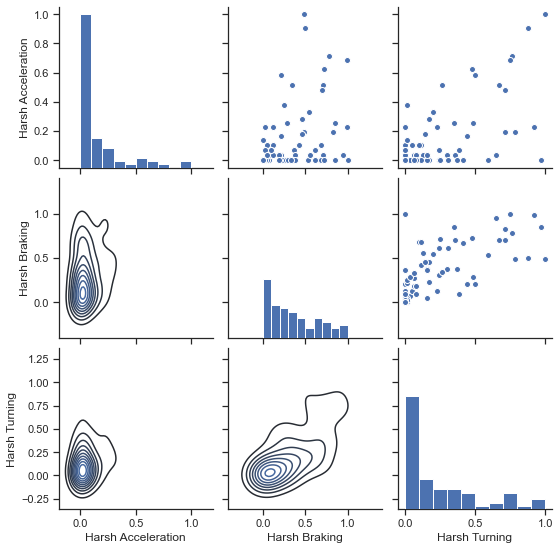

In [135]:
g = sns.PairGrid(transFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

You can see that the distribution is not symmetric yet, but not as skewed as the original data.
Let's use the mean + k std rule:

In [137]:
### remove outliers
import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor = 2.5, normalize = False):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal(x,min_max_transform=False)

    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    if normalize:
        #Normalize to [0,1]
        x = (x - np.min(x)) / (np.max(x)-np.min(x))
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x,normalize=True)))
#cleanFeatures.head(6)

Harsh Acceleration
found outlier with factor: 2.5 : [ 7 15 43]
replacing outliers [ 7 15 43] with max=0.001261107433610904
Harsh Acceleration
found outlier with factor: 2.5 : [ 7 15 43]
replacing outliers [ 7 15 43] with max=0.001261107433610904
Harsh Braking
No outliers found
Harsh Turning
found outlier with factor: 2.5 : [43 58]
replacing outliers [43 58] with max=0.005910673760657314


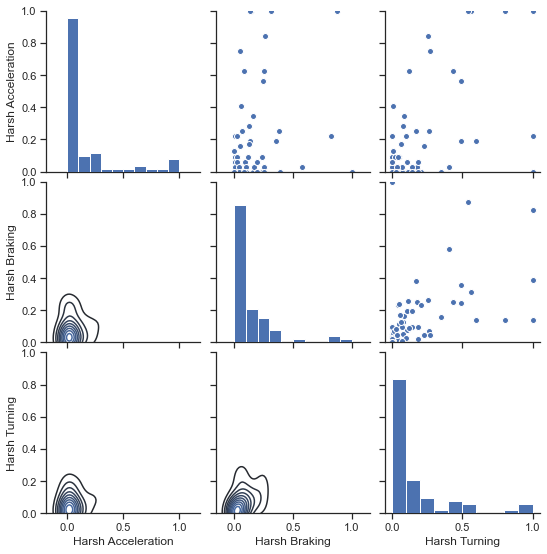

In [139]:
g = sns.PairGrid(cleanFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.set(ylim=((cleanFeatures.min().min()),(cleanFeatures.max().max())))

## Modeling
#### Main hypothesis

Our main assumption while analyzing this data was that the more events a driver had, the more likely he/she was to be an unsafe driver. A driver with zero harsh turns, zero harsh accelerations, zero over speeding and zero harsh braking over some distance, was more likely to be classified as a safe driver. On the contrary, we can assume that a driver who made multiple harsh movements over the same distance was an unsafe driver.
Modeling approaches

- Reducing the dimension to 1 and trying to find a rule/rank on this one unified metric.
    Using a univariate statistical model: modeling each event type individually by using statistical distributions.



In [141]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())


## Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


Min and Max values per column before normalization
Harsh Acceleration range:[0.0,1.0]
Harsh Braking range:[0.0,1.0]
Harsh Turning range:[0.0,1.0]

Mean and STD before standardization
Harsh Acceleration range:[0.14277969246762673,0.22772654494259667]
Harsh Braking range:[0.3512562914684069,0.29998876049515644]
Harsh Turning range:[0.24200768498343056,0.28557467888638266]


### The selected model: comparing each driver to a homogeneous population

In the end, we decided to use the technique of modeling the distribution of each event, and then evaluating each individual car by comparing it to general data from the overall homogeneous population. Since all events had a skewed distribution, we decided to use an exponential or gamma distribution. In this approach, instead of using a multivariate model that might be difficult to explain, we used a weighted sum of probabilities. For each event distribution, we estimated the Cumulative Distribution Function (CDF) value, and performed a weighted sum across all event types.

Additionally, it is possible to evaluate the goodness-of-fit or the SSE measure between the data and the proposed distribution, to detect drifts or changes in the data that might affect the model once it is finally deployed to production.

#### Extract statistics from the fitted distributions

In [142]:
mp=normalizedFeatures['Harsh Braking']
mp=mp[mp>0]
a=st.expon.fit(mp)
print(a)
print(a[-1])

(0.005488364294068898, 0.15877216565947974)
0.15877216565947974


In [143]:
import scipy.stats as st

def fit_distribution_params(series):
    print("Extracting distribution parameters for feature: " + series.name + " (" + str(len(series)) + ' values)')
    xPositive = series[series>0]
    
    if(len(xPositive)>0):
        params = st.expon.fit(xPositive)
        loc = params[0]
        scale = params[1]
        print('params =  {}, {}.'.format(loc,scale))
        return loc, scale


## Store each fitted distribution parameters for later use
fittedParams = {}
for col in normalizedFeatures.columns:
    loc,scale = fit_distribution_params(normalizedFeatures[col])
    fittedParams[col] = {}
    fittedParams[col]['loc'] = loc
    fittedParams[col]['scale'] = scale


Extracting distribution parameters for feature: Harsh Acceleration (72 values)
params =  0.031219008221214883, 0.23605040141435157.
Extracting distribution parameters for feature: Harsh Braking (72 values)
params =  0.005488364294068898, 0.15877216565947974.
Extracting distribution parameters for feature: Harsh Turning (72 values)
params =  0.006673692704154144, 0.20429676779160352.


In [144]:
def calculate_score_for_series(x,fittedParams,dummyvar):
    xPositive = x[x>0]
    probs = np.zeros(len(x))
    
    if(len(xPositive)>0):
        loc = fittedParams[x.name]['loc']
        scale = fittedParams[x.name]['scale']
        probs[x>0] = st.expon.cdf(xPositive, loc=loc, scale=scale)
        return probs

perFeatureScores = normalizedFeatures.apply(calculate_score_for_series,args=(fittedParams,"dummyvar"),axis=0)
perFeatureScores.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
0,0.0000,0.7886,0.5574
1,0.0002,0.2417,0.0000
2,0.7339,0.6330,0.3240
3,0.0000,0.6205,0.8110
4,0.4842,0.5637,0.9452


Harsh Acceleration
sse: 298.6189495529678
Harsh Braking
sse: 70.71474306975857
Harsh Turning
sse: 79.52296582683337


Text(0, 0.5, 'Number of drivers')

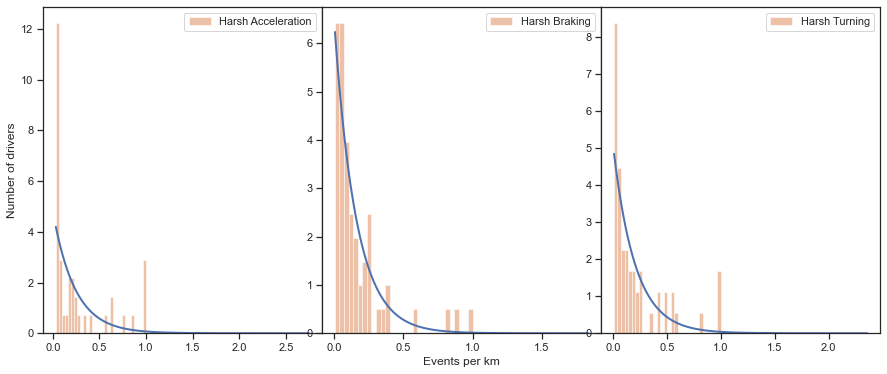

In [145]:
## Plot each fitted distribution
DIST = st.expon

def create_pdf(dist, params, size=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99999, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## fit exponential distribution
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for col in normalizedFeatures:
    print(col)
    feature = normalizedFeatures[col]
    x = feature.values[feature.values > 0] # only fit positive values to keep the distribution tighter
   
    params = DIST.fit(x)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
   
    #Plot
    pdfForPlot = create_pdf(DIST,params)
    pdfForPlot.plot(lw=2, label='PDF',ax=axs[i])
    
    #Plot
    feature[feature.values >0].plot(kind='hist', bins=30, density=True, alpha=0.5, label=feature.name, legend=True,ax=axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    ## Calculate SSE
    yhist, xhist = np.histogram(x, bins=60, density=True)
    xhist = (xhist + np.roll(xhist, -1))[:-1] / 2.0
    histPdf = DIST.pdf(xhist, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(yhist - histPdf, 2.0))
    print("sse:",sse)
    i+=1
axs[1].set_xlabel('Events per km')
axs[0].set_ylabel('Number of drivers')

    

#### Create a single metric
The commulative metric is the sum (or weighted sum) of CDFs per event type. here we assume that features have equal weights.

In [146]:
def calculate_joint_score(perFeatureScores):
    driverScores = perFeatureScores
    featureCols = [col for col in driverScores if col.startswith('Harsh')]
    driverScores['metric'] = (driverScores[featureCols].sum(axis = 1) / 3.0)
    driverScores = driverScores.sort_values('metric')
    driverScores['rank'] = (driverScores.metric.rank(method="min")-1)/((len(perFeatureScores)-1)*1.0)
    return driverScores

driverScores = calculate_joint_score(perFeatureScores)

perFeatureScores

,Harsh Acceleration,Harsh Braking,Harsh Turning,metric
0,0.0000,0.7886,0.5574,0.4487
1,0.0002,0.2417,0.0000,0.0806
2,0.7339,0.6330,0.3240,0.5636
3,0.0000,0.6205,0.8110,0.4772
4,0.4842,0.5637,0.9452,0.6644
...,...,...,...,...
67,0.0000,0.9981,0.0000,0.3327
68,0.0000,0.0000,0.0000,0.0000
69,0.0000,0.3845,0.0936,0.1594
70,0.8951,0.7821,0.9050,0.8608


Since the entire population won't be available on test time, we fit a simple linear model to find the relation between the metric (weighted sum of CDFs) and the rank (the position in the population). We will use the metric value at test time, and this model to estimate the driver's hypothetical rank in this population. Since we are doing in-population analysis, and this is a very simple model, there's no need for train/test split.

In [147]:
from sklearn.linear_model import LinearRegression

def get_linear_model(perFeatureScores):
    driverScores = calculate_joint_score(perFeatureScores)
    reg = LinearRegression()
    x = driverScores['metric'].values.reshape(-1, 1)
    y = driverScores['rank'].values.reshape(-1, 1)
    reg.fit(x,y)
    return reg

def get_rank(regModel,metric):
    rank = regModel.predict(metric)
    rank = np.asscalar(np.where(rank > 1,1,rank))
    rank = np.asscalar(np.where(rank < 0,0,rank))
    return rank

regModel = get_linear_model(perFeatureScores)
sampleRank = get_rank(regModel,[[0.5]])
#sampleRank

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


In [148]:
## Top 10 safest drivers?
driverScores.head(10)

,Harsh Acceleration,Harsh Braking,Harsh Turning,metric,rank
46,0.0000,0.0000,0.0000,0.0000,0.0000
50,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.0000,0.0000,0.0000,0.0000,0.0000
31,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000
66,0.0000,0.0000,0.0000,0.0000,0.0000
28,0.0000,0.0000,0.0000,0.0000,0.0000
26,0.0000,0.0000,0.0000,0.0000,0.0000
65,0.0000,0.0000,0.0000,0.0000,0.0000
20,0.0000,0.0000,0.0000,0.0000,0.0000


In [149]:
## top 10 most risky drivers?
driverScores.tail(10)

,Harsh Acceleration,Harsh Braking,Harsh Turning,metric,rank
39,0.6046,0.9081,0.5434,0.6854,0.8732
61,0.4850,0.8910,0.9051,0.7604,0.8873
47,0.9680,0.8031,0.7012,0.8241,0.9014
36,0.5481,0.9942,0.9923,0.8449,0.9155
43,0.9835,0.5640,0.9923,0.8466,0.9296
15,0.9835,0.5788,0.9801,0.8475,0.9437
70,0.8951,0.7821,0.9050,0.8608,0.9577
16,0.9192,0.7890,0.8762,0.8614,0.9718
7,0.9835,0.8555,0.9333,0.9241,0.9859
41,0.9835,0.9958,0.9265,0.9686,1.0000


## Distributions of CDFs, rank and metric values

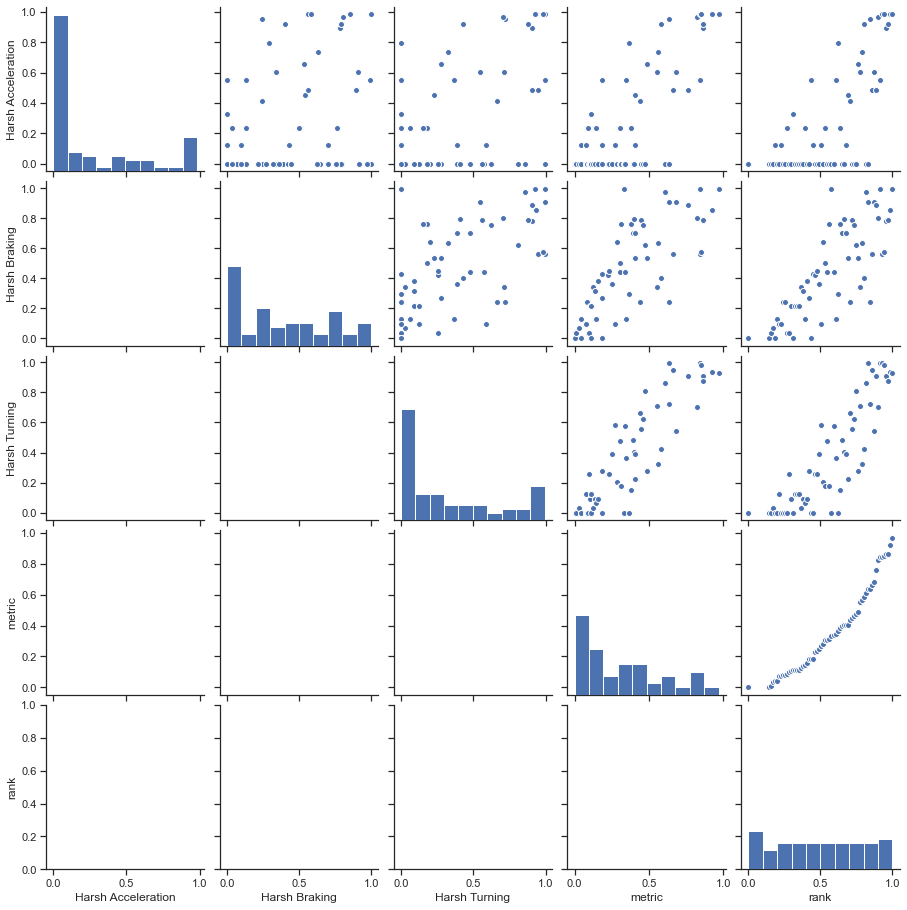

In [150]:
import seaborn as sns
sns.set(style="ticks")
g = sns.PairGrid(driverScores)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

### Estimating safety for an arbitrary subscriber
The following process estimates the score of a new driver:
1. Calculate features - number of events per km
2. Calculate CDFs by estimating the CDF per feature value using the fitted functions during 'training'. We use the function's parameters to estimate the CDF per new value.
3. Calculate the weighted sum metric. The value of this metric corresponds to the point in the population this new driver resides in.
4. Calculate a rank within a population

In [151]:
safeDriver = [{'Harsh Acceleration':0.005,
                       'Harsh Braking':0.005,
                       'Harsh Turning':0.005}]

riskyDriver = [{'Harsh Acceleration':0.2,
                       'Harsh Braking':0.16,
                       'Harsh Turning':0.28}]

safeDriverDf = pd.DataFrame(safeDriver,index = None)
riskyDriverDf = pd.DataFrame(riskyDriver,index = None)

print('****** Estimated safety scores ******')
def get_score_one_driver(driverDf,fittedParams,minPerFeature,maxPerFeature):

    normalized = (driverDf - minPerFeature) / (maxPerFeature - minPerFeature)
    scoreDF = pd.DataFrame()
    for col in normalized:
        scoreDF[col] = calculate_score_for_series(normalized[col],fittedParams,True)
    scoreDF = calculate_joint_score(scoreDF)
    return scoreDF


safeDriverWithMetric = get_score_one_driver(safeDriverDf, fittedParams,minPerFeature,maxPerFeature)
riskyDriverWithMetric = get_score_one_driver(riskyDriverDf, fittedParams,minPerFeature,maxPerFeature)

safeDriverMetric = safeDriverWithMetric['metric'].values[0]
riskyDriverMetric = riskyDriverWithMetric['metric'].values[0]


print('------')
print("Rank for safe driver = {}".format(get_rank(regModel,[[safeDriverMetric]])))
print("Metric for safe driver = {}".format(safeDriverMetric))
print('------')
print("Rank for risky driver = {}".format(get_rank(regModel,[[riskyDriverMetric]])))
print("Metric for risky driver = {}".format(riskyDriverMetric))


****** Estimated safety scores ******
------
Rank for safe driver = 0.1628305386880567
Metric for safe driver = 0.0
------
Rank for risky driver = 0.808535655506591
Metric for risky driver = 0.6235113940228378


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


There are two alternatives here for results: the metric (weighted sum), which gives a score with regards to the amount of events of each type, and the rank, which shows on which percentile of the population the driver is. Depending on the use case, one can decide on the right metric.
Since the relation between these two metrics is not 100% linear, we get different results than the training set. In this case we get a rank of 0.28 and metric of 0.15 for a driver with almost 0 events.